## Загрузим нужные библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
%matplotlib inline

В начале остановимся на наиболее перспективных навыках

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df_calls = pd.read_csv("Calls.csv")
df_connection_time = pd.read_csv("ConnectionTime.csv")
df_ed = pd.read_csv("Education.csv")

/tmp/ipykernel_8415/2175504698.py:5: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_connection_time = pd.read_csv("ConnectionTime.csv")


## Рассмотрим датасет по ближе

In [3]:
df_calls.head(3)

,Date,CallTime,NumberOfCalls,Вид учета времени,InOut,id
0,"2021-08-16 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
1,"2021-09-21 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945
2,"2021-01-11 00:00:00,000","0,00027777777777777778",1,Будни,ToUser,ОРГ1-01945


In [4]:
df_connection_time.head(3)

,dateNum,maxLogOff,Нормативное время начала раб.дня,Фактич. время начала раб.дня,Время опоздания,Признак опоздания,Вых/Будни,id
0,"2021-12-15 00:00:00,000","2021-12-15 17:30:27,246","1899-12-30 08:30:00,000","1899-12-30 08:24:18,606",NaN,NaN,Будни,ОРГ1-02782
1,"2021-12-15 00:00:00,000","2021-12-15 16:30:13,330","1899-12-30 08:30:00,000","1899-12-30 01:05:20,513",NaN,NaN,Будни,ОРГ1-01407
2,"2021-12-15 00:00:00,000","2021-12-15 15:27:37,246","1899-12-30 08:30:00,000","1899-12-30 05:47:33,156",NaN,NaN,Будни,ОРГ1-01909


In [5]:
df_ed.head(3)

,Табельный номер руководителя,id,Вид образования,Специальность
0,NaN,ОРГ1-00131,Высшее образование - бакалавриат,Юриспруденция
1,NaN,ОРГ1-03220,Среднее профессиональное образование,Финансы
2,NaN,ОРГ1-03008,Высшее образование,Юриспруденция


In [6]:
df_train.head(3)

,id,type
0,ОРГ1-02050,2
1,ОРГ1-02783,2
2,ОРГ2-06173,0


In [7]:
df_test.head(3)

,id,type
0,ОРГ1-02649,0
1,ОРГ2-05929,0
2,ОРГ2-05859,0


Узнаем размерность наборов

In [8]:
print("df_train", df_train.shape)
print("df_calls", df_calls.shape)
print("df_connection_time", df_connection_time.shape)
print("df_ed", df_ed.shape)
print("df_test", df_test.shape)

df_train (550, 2)
df_calls (407867, 6)
df_connection_time (230662, 8)
df_ed (5609, 4)
df_test (262, 2)


### Видоизмение данных

Обьединим два набора с данными

In [9]:
df_train = pd.merge(df_train, df_ed , on="id", how='left').drop_duplicates(subset="id")

df_train.head(3)

,id,type,Табельный номер руководителя,Вид образования,Специальность
0,ОРГ1-02050,2,NaN,Неполное высшее образование,Технологические машины и оборудование
2,ОРГ1-02783,2,ОРГ1-01974,Высшее образование,Автоматизация технологических процессов и прои...
3,ОРГ2-06173,0,ОРГ2-01170,Высшее образование,Управление качеством


In [10]:
df_train = df_train.drop(["Табельный номер руководителя", "Специальность"],axis = 1)

df_train["Вид образования"].value_counts()

Высшее образование                                297
Среднее профессиональное образование               64
Высшее образование - бакалавриат                   59
Высшее образование - специалитет, магистратура     30
Начальное профессиональное образование              7
Повышение квалификации                              7
Неполное высшее образование                         5
Среднее общее образование                           3
Среднее (полное) общее образование                  2
Переподготовка                                      2
Профессиональное обучение                           1
Name: Вид образования, dtype: int64

In [11]:
df_train["Вид образования"] = df_train["Вид образования"].astype('category')
df_train["Вид образования"] = df_train["Вид образования"].cat.codes

df_train["Вид образования"].value_counts()

 0     297
-1      73
 10     64
 1      59
 2      30
 3       7
 6       7
 4       5
 9       3
 8       2
 5       2
 7       1
Name: Вид образования, dtype: int64

Оставим только столбец - опоздания сотрудников

In [12]:
df_connection_time_res = df_connection_time[["id","Признак опоздания"]]
df_connection_time_res = df_connection_time_res[df_connection_time_res["Признак опоздания"].notna()]

df_connection_time_res.head()

,id,Признак опоздания
127561,ОРГ1-01589,Опоздание
127562,ОРГ1-01589,Опоздание
127563,ОРГ1-01589,Опоздание
127564,ОРГ1-01589,Опоздание
127565,ОРГ1-01589,Опоздание


In [13]:
df_connection_time_res = df_connection_time_res.groupby("id").count()
df_connection_time_res = df_connection_time_res.rename(columns={"Признак опоздания": "Число опозданий"})

df_connection_time_res.head(3)

,Число опозданий
id,
ОРГ1-00004,275
ОРГ1-00028,35
ОРГ1-00030,57


In [14]:
df_train = pd.merge(df_train, df_connection_time_res , on="id", how='left')#.drop(["event_type"],axis =1)

df_train.head(3)

,id,type,Вид образования,Число опозданий
0,ОРГ1-02050,2,4,5.0
1,ОРГ1-02783,2,0,7.0
2,ОРГ2-06173,0,0,22.0


In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 0 to 549
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               550 non-null    object 
 1   type             550 non-null    int64  
 2   Вид образования  550 non-null    int8   
 3   Число опозданий  491 non-null    float64
dtypes: float64(1), int64(1), int8(1), object(1)
memory usage: 17.7+ KB


## Добавим суммарное время звонков!



In [16]:
def str_to_float(str):
    str=str.replace(',','')
    return float(str)

df_calls['CallTime']=df_calls['CallTime'].map(str_to_float)
CallTime=pd.DataFrame(df_calls.groupby('id')['CallTime'].sum()).reset_index()
df_train = pd.merge(df_train, CallTime , on="id", how='left')
df_train

,id,type,Вид образования,Число опозданий,CallTime
0,ОРГ1-02050,2,4,5.0,4.810983e+18
1,ОРГ1-02783,2,0,7.0,1.350599e+19
2,ОРГ2-06173,0,0,22.0,NaN
3,ОРГ2-05359,2,10,6.0,NaN
4,ОРГ1-00803,2,0,35.0,1.388889e+17
...,...,...,...,...,...
545,ОРГ1-02587,2,-1,NaN,NaN
546,ОРГ1-02383,2,0,54.0,2.259805e+19
547,ОРГ1-02862,2,-1,NaN,NaN
548,ОРГ1-00471,2,-1,12.0,1.749719e+19


## Заменим пропуски на нули

In [17]:
df_train = df_train.fillna(0)

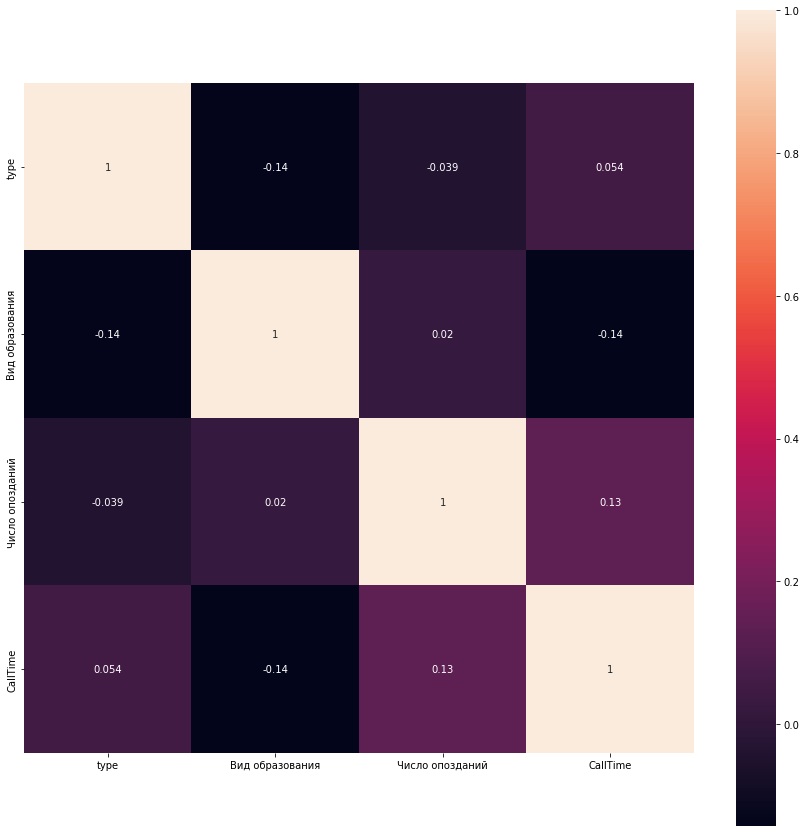

In [18]:
plt.rcParams['figure.figsize']=(15,15)

corr = df_train.corr()
g = sns.heatmap(corr, square = True, annot=True)

## Выделим выборки

In [19]:
X = df_train.drop(["id", "type"], axis = 1)
y = df_train[["type"]]

In [20]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 0 to 549
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Вид образования  550 non-null    int8   
 1   Число опозданий  550 non-null    float64
 2   CallTime         550 non-null    float64
dtypes: float64(2), int8(1)
memory usage: 13.4 KB


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Обучение модели

In [22]:
clf = RandomForestClassifier(random_state=0)

In [23]:
clf.fit(X_train, y_train)

/tmp/ipykernel_8415/2395142735.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


RandomForestClassifier(random_state=0)

## Оценка точности

In [24]:
pred = clf.predict(X_test)

In [25]:
y_test.head(3)

,type
195,2
79,2
480,0


In [26]:
from sklearn.metrics import recall_score

print("Recall score:", recall_score(y_test, pred, average='macro'))

Recall score: 0.291343669250646


In [27]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.28      0.24      0.26        45
           1       0.42      0.20      0.27        25
           2       0.55      0.72      0.62        86
           3       0.00      0.00      0.00         9

    accuracy                           0.47       165
   macro avg       0.31      0.29      0.29       165
weighted avg       0.43      0.47      0.44       165



## Генерация предсказания

In [28]:
df_test

,id,type
0,ОРГ1-02649,0
1,ОРГ2-05929,0
2,ОРГ2-05859,0
3,ОРГ1-00279,0
4,ОРГ2-01613,0
...,...,...
257,ОРГ1-02893,0
258,ОРГ2-01077,0
259,ОРГ1-00469,0
260,ОРГ1-02060,0


## Добавим фичи.

In [29]:
df_test = pd.merge(df_test, df_ed , on="id", how='left').drop_duplicates(subset="id")
df_test = df_test.drop(["Табельный номер руководителя", "Специальность"],axis = 1)
df_test["Вид образования"] = df_test["Вид образования"].astype('category')
df_test["Вид образования"] = df_test["Вид образования"].cat.codes
df_test = pd.merge(df_test, df_connection_time_res , on="id", how='left')#.drop(["event_type"],axis =1)

# Добавим суммарное время звоков

In [30]:
df_test = pd.merge(df_test, CallTime , on="id", how='left')

# Удалим пустые значения

In [31]:
df_test = df_test.fillna(0)

## Предсказания

In [32]:
df_test_pred = pd.read_csv("test.csv")
Xpred = df_test.drop(["id", "type"], axis = 1)
preds = clf.predict(Xpred)
df_test_pred['type']=preds

In [33]:
df_test_pred.to_csv('rfnev.csv', index=False)